### Step 1: Load and Inspect Brent Oil Price Data

The dataset contains historical Brent oil prices from May 1987 to September 2022. It includes the following columns:
- `Date`: The trading date (in 'day-month-year' format)
- `Price`: Brent oil price in USD per barrel

I begin by loading the dataset and inspecting the first few rows.

`Purpose:`

* Understand the structure and quality of the dataset.

In [15]:
import pandas as pd

# Load the Brent oil price dataset
file_path = "../data/BrentOilPrices.csv"
df = pd.read_csv(file_path)

# Preview
df.tail()


,Date,Price
9006,"Nov 08, 2022",96.85
9007,"Nov 09, 2022",93.05
9008,"Nov 10, 2022",94.25
9009,"Nov 11, 2022",96.37
9010,"Nov 14, 2022",93.59


### Step 2: Data Cleaning

We convert the `Date` column to proper datetime format and sort the dataset chronologically. This prepares the data for time series analysis.


In [16]:
# Convert 'Date' to datetime and sort

# Strip whitespace from column names
df.columns = df.columns.str.strip()

# Handle mixed date formats
df["Date"] = pd.to_datetime(df["Date"], format='mixed', dayfirst=True, errors="coerce")

# Drop rows with unparsed dates (NaT)
df = df.dropna(subset=["Date"])

# Sort and set Date as index
df = df.sort_values("Date")
df.set_index("Date", inplace=True)

# Final preview
df.head()


,Price
Date,
1987-05-20,18.63
1987-05-21,18.45
1987-05-22,18.55
1987-05-25,18.60
1987-05-26,18.63


In [17]:
df.tail()

,Price
Date,
2022-11-08,96.85
2022-11-09,93.05
2022-11-10,94.25
2022-11-11,96.37
2022-11-14,93.59


### Step 3: Exploratory Data Analysis

The plot below shows the daily Brent oil price over the full time range. We can observe several visible spikes, crashes, and periods of volatility, suggesting the presence of structural changes — ideal for change point analysis.


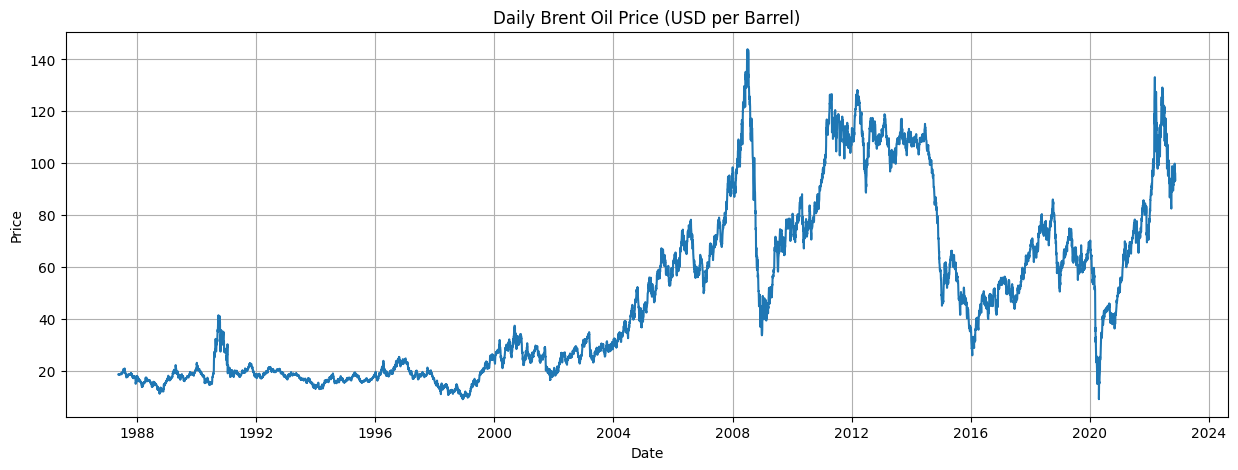

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))
plt.plot(df['Price'])
plt.title("Daily Brent Oil Price (USD per Barrel)")
plt.xlabel("Date")
plt.ylabel("Price")
plt.grid(True)
plt.show()


### Step 4: Event Timeline Dataset

We manually compile a list of 10–15 key geopolitical or economic events known to affect oil markets. This data will be used later to match against detected change points.

| event_name | start_date | description |
|------------|------------|-------------|
| Gulf War I | 1990-08-02 | Iraq invades Kuwait, triggering price spikes |
| 9/11 Attack | 2001-09-11 | U.S. terrorist attack creates demand shock |
| Iraq War | 2003-03-20 | U.S. invades Iraq, destabilizing supply |
| Financial Crisis | 2008-09-15 | Lehman collapse triggers global recession |
| Arab Spring | 2011-01-01 | Uprisings across MENA disrupt oil production |
| Crimea Crisis | 2014-03-01 | Sanctions on Russia affect global trade |
| OPEC Cut | 2016-11-30 | OPEC agrees to cut oil production |
| COVID-19 Outbreak | 2020-03-11 | WHO declares pandemic, oil demand collapses |
| COVID Recovery | 2021-01-01 | Vaccine rollout and global demand rise |
| Russia–Ukraine War | 2022-02-24 | Full-scale invasion spikes oil volatility |

➡ Save this to: `data/key_events.csv`


In [21]:
event_data = [
    {"event_name": "Gulf War I", "start_date": "1990-08-02", "description": "Iraq invades Kuwait"},
    {"event_name": "9/11 Attack", "start_date": "2001-09-11", "description": "Terrorist attack in U.S."},
    {"event_name": "Iraq War", "start_date": "2003-03-20", "description": "U.S. invades Iraq"},
    {"event_name": "Financial Crisis", "start_date": "2008-09-15", "description": "Global financial collapse"},
    {"event_name": "Arab Spring", "start_date": "2011-01-01", "description": "Middle East unrest"},
    {"event_name": "Crimea Crisis", "start_date": "2014-03-01", "description": "Sanctions on Russia"},
    {"event_name": "OPEC Cut", "start_date": "2016-11-30", "description": "OPEC agrees to production cuts"},
    {"event_name": "COVID-19 Outbreak", "start_date": "2020-03-11", "description": "WHO declares pandemic"},
    {"event_name": "COVID Recovery", "start_date": "2021-01-01", "description": "Post-pandemic demand rises"},
    {"event_name": "Russia–Ukraine War", "start_date": "2022-02-24", "description": "Russian invasion of Ukraine"}
]

event_df = pd.DataFrame(event_data)
event_df.to_csv("../data/key_events.csv", index=False)


##### Plot Brent Oil Price with Event Markers

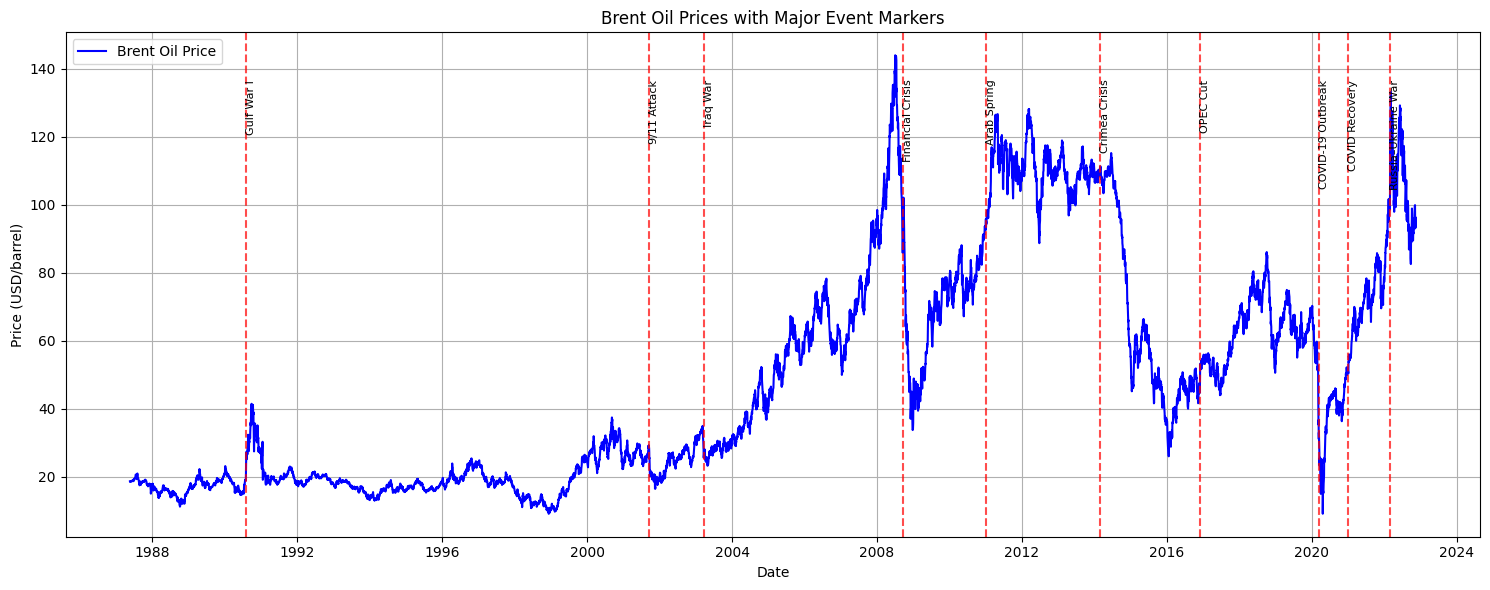

In [ ]:
# Reuse your existing df (Brent oil price with datetime index)
# Load events
events_df = pd.read_csv("../data/key_events.csv")
events_df["start_date"] = pd.to_datetime(events_df["start_date"])

# Plot price data
plt.figure(figsize=(15, 6))
plt.plot(df.index, df["Price"], label="Brent Oil Price", color='blue')

# Overlay event markers
for _, row in events_df.iterrows():
    plt.axvline(row["start_date"], color="red", linestyle="--", alpha=0.7)
    plt.text(row["start_date"], df["Price"].max()*0.95, row["event_name"], rotation=90, verticalalignment='top', fontsize=8)

# Labels
plt.title("Brent Oil Prices with Major Event Markers")
plt.xlabel("Date")
plt.ylabel("Price (USD/barrel)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### Step 5: Assumptions and Limitations

**Assumptions:**
- Historical oil prices reflect real market supply/demand dynamics and investor sentiment.
- External shocks (wars, policies) are assumed to affect prices measurably.
- The key event dataset contains sufficiently impactful events.

**Limitations:**
- Statistical change point models detect *correlation*, not *causation*.
- Change points may be driven by overlapping or latent factors not in the dataset.
- Price data is uni-variate; economic context (e.g., inflation, demand) is missing.

**Note:** Causality cannot be proven without experimental design or instrumental variable modeling. This analysis provides probabilistic evidence that certain events align with structural shifts in the data.


## ✅ Step: Analyze Time Series Properties of Brent Oil Prices

### Checking Trend and Volatility

Rolling statistics help us visualize whether the time series has a stable mean and variance — a requirement for many statistical models. 

We observe:
- A **non-constant mean** (visible trend shifts)
- **Volatility clusters**, especially during crises

Conclusion: The original price series is **non-stationary**.


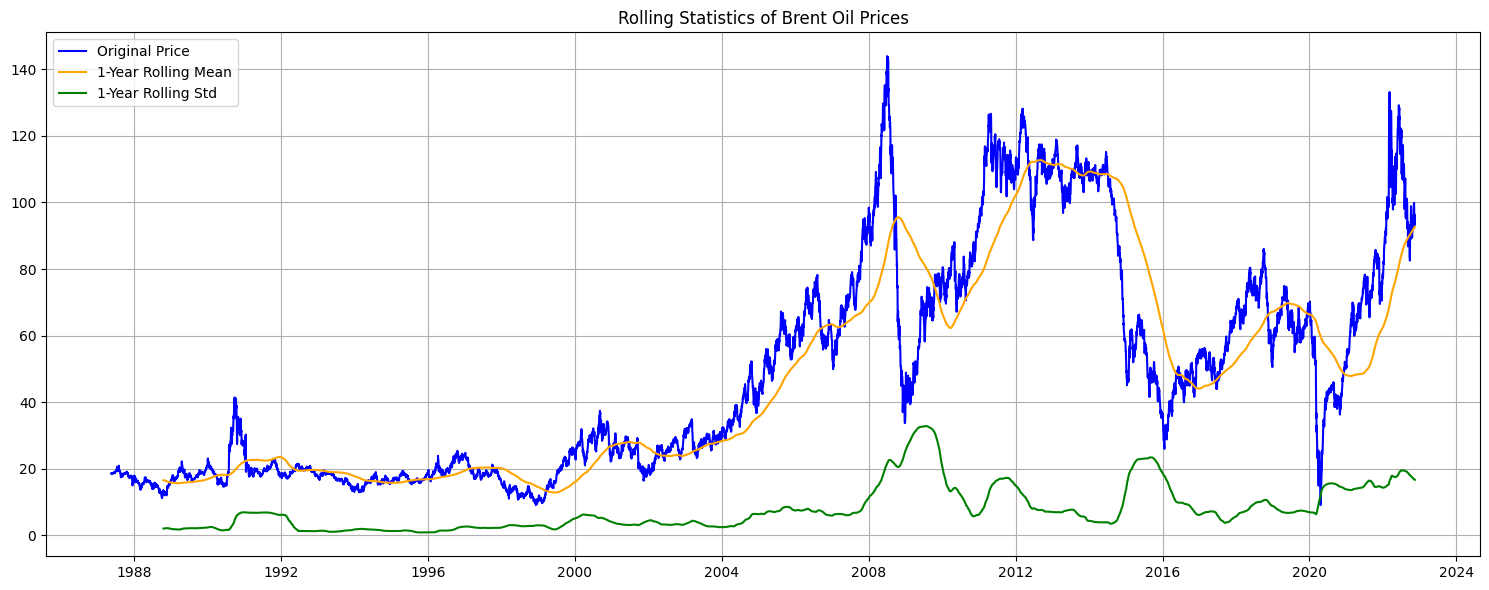

In [23]:
# Rolling statistics
rolling_mean = df['Price'].rolling(window=365).mean()
rolling_std = df['Price'].rolling(window=365).std()

# Plot
plt.figure(figsize=(15, 6))
plt.plot(df['Price'], color='blue', label='Original Price')
plt.plot(rolling_mean, color='orange', label='1-Year Rolling Mean')
plt.plot(rolling_std, color='green', label='1-Year Rolling Std')
plt.title("Rolling Statistics of Brent Oil Prices")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### Log Returns and Stationarity

We compute log returns to stabilize variance and remove trend. Log returns often show **stationary behavior**, making them more suitable for time series models like Bayesian change point detection.

The plot reveals:
- Periods of **high volatility** (e.g., 2008, 2020, 2022)
- Evidence of **volatility clustering**


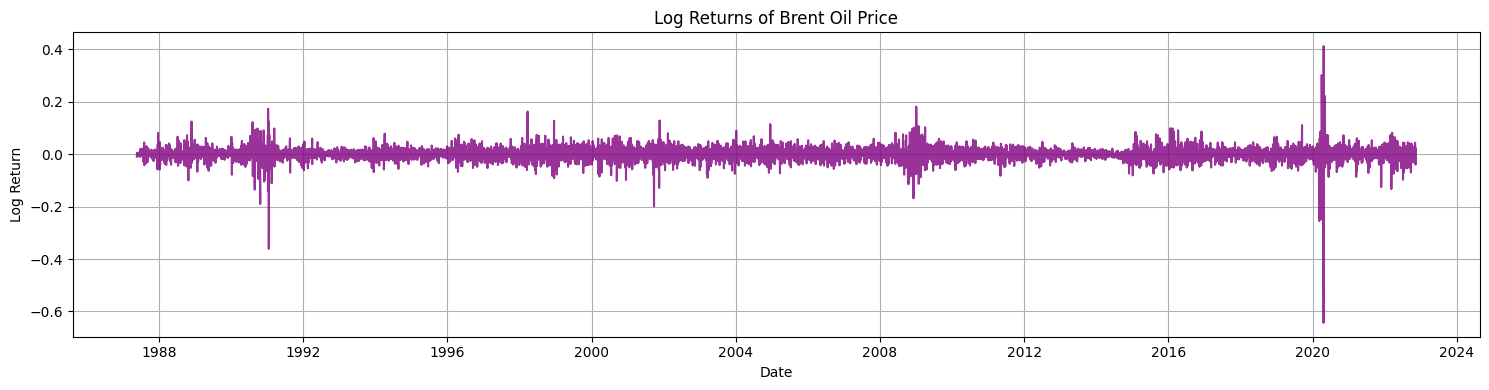

In [24]:
import numpy as np

# Log returns
df["log_price"] = np.log(df["Price"])
df["log_return"] = df["log_price"].diff()
df = df.dropna(subset=["log_return"])

# Plot log returns
plt.figure(figsize=(15, 4))
plt.plot(df["log_return"], color='purple', alpha=0.8)
plt.title("Log Returns of Brent Oil Price")
plt.ylabel("Log Return")
plt.xlabel("Date")
plt.grid(True)
plt.tight_layout()
plt.show()


### Augmented Dickey-Fuller Test

We apply the ADF test to formally test for stationarity.

- **Null Hypothesis (H₀)**: Series is non-stationary
- **Alternative Hypothesis (H₁)**: Series is stationary

If p-value < 0.05, we reject H₀.

In this case, the log returns are **likely stationary**, validating our transformation.


In [26]:
from statsmodels.tsa.stattools import adfuller

# ADF test
result = adfuller(df['log_return'].dropna())
print("ADF Statistic:", result[0])
print("p-value:", result[1])


ADF Statistic: -16.427113494485894
p-value: 2.4985801611428892e-29


### Why Use Change Point Models?

**Change point models** detect moments in time where the data's statistical properties change. In the context of Brent oil prices, they allow us to:

- Identify structural breaks caused by geopolitical/economic shocks
- Quantify how price behavior (mean, volatility) changes before and after events
- Model uncertainty around the timing and magnitude of changes

This helps investors and policymakers understand *when* and *how* global events affect oil markets.

**Expected Outputs of Change Point Models:**
- Dates of statistically significant change points
- Posterior distributions over pre- and post-change parameters (e.g., mean or variance)
- Uncertainty quantification
- Association of detected changes with real-world events

**Limitations:**
- Change point detection shows correlation, not causation
- Multiple factors may overlap, making attribution complex
- Choice of model (mean vs. variance changes) affects interpretation
